In [1]:
import os, sys
import os.path as osp
root_dir = osp.dirname(osp.dirname(os.getcwd()))
package_dir = osp.join(root_dir, 'src')
sys.path.append(package_dir)
from ml_modules.data.datasets import DeepSTABp_Dataset
from ml_modules.data.transforms import norm_0to1

import torch
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
plt.rc('axes', axisbelow=True)
plt.rcParams.update({'figure.autolayout': True})

dataset = DeepSTABp_Dataset(
    experiment='lysate',
    organism=None,
    cell_line=None,
    version='v5-sigma2_cutoff12_species',
    transform=None
)
dataset_trans = DeepSTABp_Dataset(
    experiment='lysate',
    organism=None,
    cell_line=None,
    version='v5-sigma2_cutoff12_species',
    transform=norm_0to1
)
Tm_dict = dataset.Tm_dict

species2idx = {
    "Oleispira antarctica": 0,
    "Caenorhabditis elegans": 1,
    "Arabidopsis thaliana": 2,
    "Drosophila melanogaster": 3,
    "Danio rerio": 4,
    "Saccharomyces cerevisiae": 5,
    "Bacillus subtilis": 6,
    "Escherichia coli": 7,
    "Homo sapiens": 8,
    "Mus musculus": 9,
    "Geobacillus stearothermophilus": 10,
    "Picrophilus torridus": 11,
    "Thermus thermophilus": 12
}
cm = plt.get_cmap('gist_rainbow')

edge_types = ['backbone', 'codir', 'pae', 'coord', 'contact', 'deform']

 -> Generating dataset from c:\Users\yenlin\Dropbox\projects\ai-thermostability\code\data\collation\DeepSTABp\lysate.csv
 -> Number of entries in meta file    : 29757
     >> mean value of Tm  : 49.8242
     >> range of Tm       : 30.4417-92.5729
 -> Number of unique accessions       : 29757
 -> Final number of accessions        : 20255
     >> mean value of Tm: 50.4288
     >> range of Tm     : 30.4417-92.5729
 -> Number of unique accessions       : 20255
Dataset instantiation complete.
 -> Generating dataset from c:\Users\yenlin\Dropbox\projects\ai-thermostability\code\data\collation\DeepSTABp\lysate.csv
 -> Number of entries in meta file    : 29757
     >> mean value of Tm  : 49.8242
     >> range of Tm       : 30.4417-92.5729
 -> Number of unique accessions       : 29757
 -> Final number of accessions        : 20255
     >> mean value of Tm: 50.4288
     >> range of Tm     : 30.4417-92.5729
 -> Number of unique accessions       : 20255
Dataset instantiation complete.


In [2]:
# GATHER ALL REQUIRED INFORMATION

all_Tm = []
all_ogt = []
all_species = []
all_seq_length = []
pLDDT_by_protein = []
bfactors_by_protein = []
edge_count = {edge_type: [] for edge_type in edge_types}

pbar = tqdm(dataset)
for i, data in enumerate(pbar):
    pbar.set_description(data['accession'])

    all_Tm.append(Tm_dict[data['accession']])
    all_ogt.append(data.ogt)
    all_species.append(data.species)
    all_seq_length.append(data['residue'].num_nodes)
    pLDDT_by_protein.append(data['residue'].pLDDT.tolist())
    bfactors_by_protein.append(data['residue'].bfactor.tolist())
    
    for edge_type in edge_types:
        edge_count[edge_type].append(
            data['residue', edge_type, 'residue'].edge_index.shape[1]/2
        )

all_pLDDT = [e for protein in pLDDT_by_protein for e in protein]
all_bfactors = [e for protein in bfactors_by_protein for e in protein]

all_pLDDT_mean = [np.mean(e) for e in pLDDT_by_protein]
all_pLDDT_max = [np.max(e) for e in pLDDT_by_protein]
all_pLDDT_min = [np.min(e) for e in pLDDT_by_protein]
all_bfactor_mean = [np.mean(e) for e in bfactors_by_protein]
all_bfactor_max = [np.max(e) for e in bfactors_by_protein]
all_bfactor_min = [np.min(e) for e in bfactors_by_protein]

  0%|          | 0/20255 [00:00<?, ?it/s]

In [3]:
# sort entries by ogt

sorted_idx = np.argsort(all_ogt)

all_Tm = np.array(all_Tm)[sorted_idx]
all_ogt = np.array(all_ogt)[sorted_idx]
all_species = np.array(all_species)[sorted_idx]
all_seq_length = np.array(all_seq_length)[sorted_idx]

pLDDT_by_protein = [pLDDT_by_protein[i] for i in sorted_idx]
bfactors_by_protein = [bfactors_by_protein[i] for i in sorted_idx]

edge_count = {
    edge_type: np.array(edge_count[edge_type])[sorted_idx]
    for edge_type in edge_types
}

all_pLDDT_mean = np.array(all_pLDDT_mean)[sorted_idx]
all_pLDDT_max = np.array(all_pLDDT_max)[sorted_idx]
all_pLDDT_min = np.array(all_pLDDT_min)[sorted_idx]
all_bfactor_mean = np.array(all_bfactor_mean)[sorted_idx]
all_bfactor_max = np.array(all_bfactor_max)[sorted_idx]
all_bfactor_min = np.array(all_bfactor_min)[sorted_idx]

In [27]:
all_ogt

array([ 3.,  3.,  3., ..., 70., 70., 70.])

In [20]:
save = True

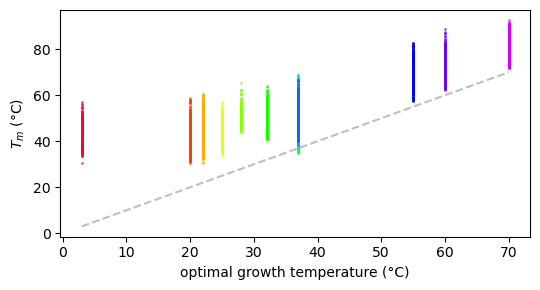

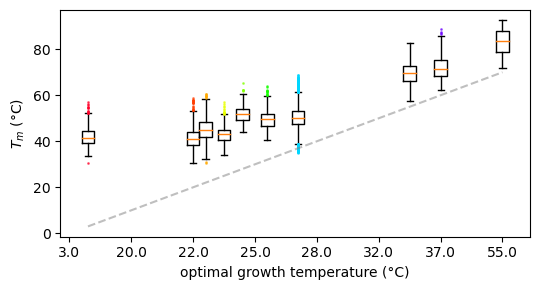

In [21]:
# species vs Tm

### SCATTER PLOT
plt.figure(figsize=(5.5, 3))
# plt.gca().set_aspect('equal')

for species in np.unique(all_species):
    plt.scatter(
        all_ogt[all_species==species],
        all_Tm[all_species==species],
        color=cm(species2idx[species]/len(species2idx)),
        s=1,
        alpha=0.6
    )

plt.plot(np.linspace(3,70), np.linspace(3,70), '--', c='gray', alpha=0.5)

plt.xlabel('optimal growth temperature (°C)')
plt.ylabel(r'$T_m$ (°C)')
plt.xticks(ticks=np.arange(0, 80, 10))
# plt.grid()
if save:
    plt.savefig('ogt_vs_Tm.png', dpi=300)#, bbox_inches='tight')
plt.show()
plt.close()



### BOX PLOT
plt.figure(figsize=(5.5, 3))
# plt.gca().set_aspect('equal')

for ogt in np.unique(all_ogt):
    species = all_species[all_ogt==ogt][0]
    plt.boxplot(
        all_Tm[all_ogt==ogt],
        positions=all_ogt[all_ogt==ogt][[0]],
        widths=2,
        notch=False,
        flierprops={
            'markerfacecolor': cm(species2idx[species]/len(species2idx)),
            'markeredgecolor': cm(species2idx[species]/len(species2idx)),
            'markersize': 1,
            'alpha': 0.6
        }
    )

plt.plot(np.linspace(3,70), np.linspace(3,70), '--', c='gray', alpha=0.5)

plt.xlabel('optimal growth temperature (°C)')
plt.ylabel(r'$T_m$ (°C)')
plt.xticks(ticks=np.arange(0, 80, 10))
# plt.grid()
if save:
    plt.savefig('ogt_box_vs_Tm.png', dpi=300)#, bbox_inches='tight')
plt.show()
plt.close()


In [25]:
all_species

array(['Oleispira antarctica', 'Oleispira antarctica',
       'Oleispira antarctica', ..., 'Thermus thermophilus',
       'Thermus thermophilus', 'Thermus thermophilus'], dtype='<U30')

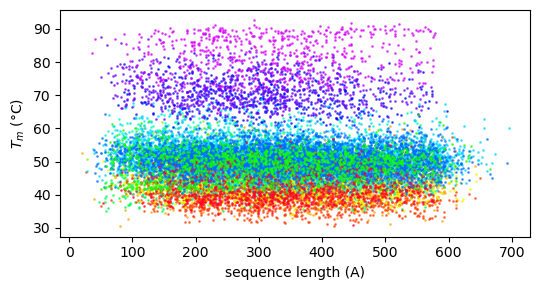

In [22]:
# seq length vs Tm

plt.figure(figsize=(5.5, 3))

for species in np.unique(all_species):
    plt.scatter(
        all_seq_length[all_species==species],
        all_Tm[all_species==species],
        color=cm(species2idx[species]/len(species2idx)),
        s=1,
        alpha=0.6
    )

plt.xlabel('sequence length (A)')
plt.ylabel(r'$T_m$ (°C)')
# plt.grid()
if save:
    plt.savefig('seq_length_vs_Tm.png', dpi=300)#, bbox_inches='tight')
plt.show()
plt.close()

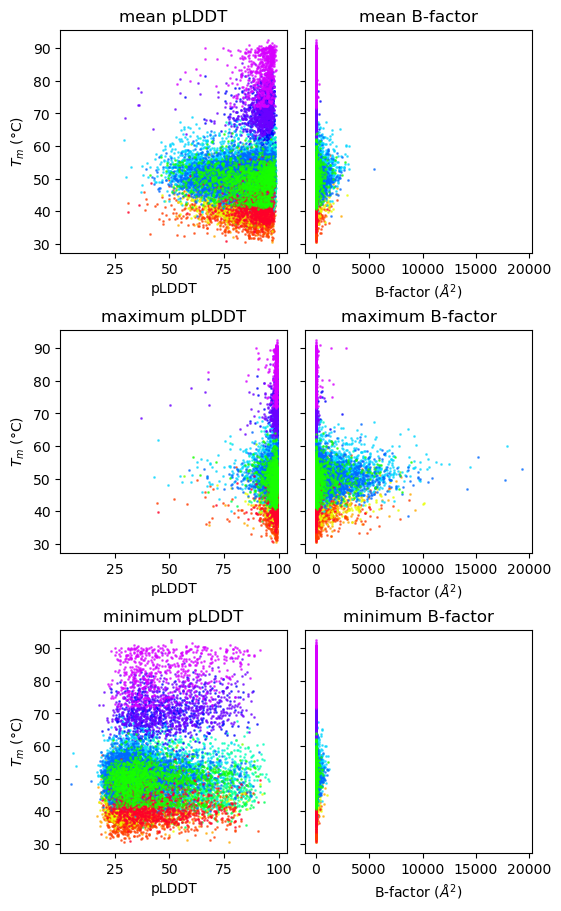

In [23]:
# pLDDT / bfactor vs Tm

fig, ax = plt.subplots(
    3, 2, sharex='col', sharey=True, figsize=(5.5, 9), layout='compressed'
)
ax = ax.flatten()

### pLDDT MEAN
for species in np.unique(all_species):
    ax[0].scatter(
        all_pLDDT_mean[all_species==species],
        all_Tm[all_species==species],
        color=cm(species2idx[species]/len(species2idx)),
        s=1,
        alpha=0.6
    )
ax[0].set_title('mean pLDDT')
ax[0].set_xlabel('pLDDT')
ax[0].set_ylabel(r'$T_m$ (°C)')
ax[0].tick_params(labelbottom=True)

### B-FACTOR MEAN
for species in np.unique(all_species):
    ax[1].scatter(
        all_bfactor_mean[all_species==species],
        all_Tm[all_species==species],
        color=cm(species2idx[species]/len(species2idx)),
        s=1,
        alpha=0.6
    )
ax[1].set_title(r'mean B-factor')
ax[1].set_xlabel(r'B-factor ($\AA^2$)')
ax[1].tick_params(labelbottom=True)

### pLDDT MAX
for species in np.unique(all_species):
    ax[2].scatter(
        all_pLDDT_max[all_species==species],
        all_Tm[all_species==species],
        color=cm(species2idx[species]/len(species2idx)),
        s=1,
        alpha=0.6
    )
ax[2].set_title('maximum pLDDT')
ax[2].set_xlabel('pLDDT')
ax[2].set_ylabel(r'$T_m$ (°C)')
ax[2].tick_params(labelbottom=True)

### B-FACTOR MAX
for species in np.unique(all_species):
    ax[3].scatter(
        all_bfactor_max[all_species==species],
        all_Tm[all_species==species],
        color=cm(species2idx[species]/len(species2idx)),
        s=1,
        alpha=0.6
    )
ax[3].set_title(r'maximum B-factor')
ax[3].set_xlabel(r'B-factor ($\AA^2$)')
ax[3].tick_params(labelbottom=True)

### pLDDT MIN
for species in np.unique(all_species):
    ax[4].scatter(
        all_pLDDT_min[all_species==species],
        all_Tm[all_species==species],
        color=cm(species2idx[species]/len(species2idx)),
        s=1,
        alpha=0.6
    )
ax[4].set_title('minimum pLDDT')
ax[4].set_xlabel('pLDDT')
ax[4].set_ylabel(r'$T_m$ (°C)')

### B-FACTOR MIN
for species in np.unique(all_species):
    ax[5].scatter(
        all_bfactor_min[all_species==species],
        all_Tm[all_species==species],
        color=cm(species2idx[species]/len(species2idx)),
        s=1,
        alpha=0.6
    )
ax[5].set_title(r'minimum B-factor')
ax[5].set_xlabel(r'B-factor ($\AA^2$)')

if save:
    plt.savefig('pLDDT_bfactor_vs_Tm.png', dpi=300)#, bbox_inches='tight')
plt.show()
plt.close()

  0%|          | 0/6 [00:00<?, ?it/s]

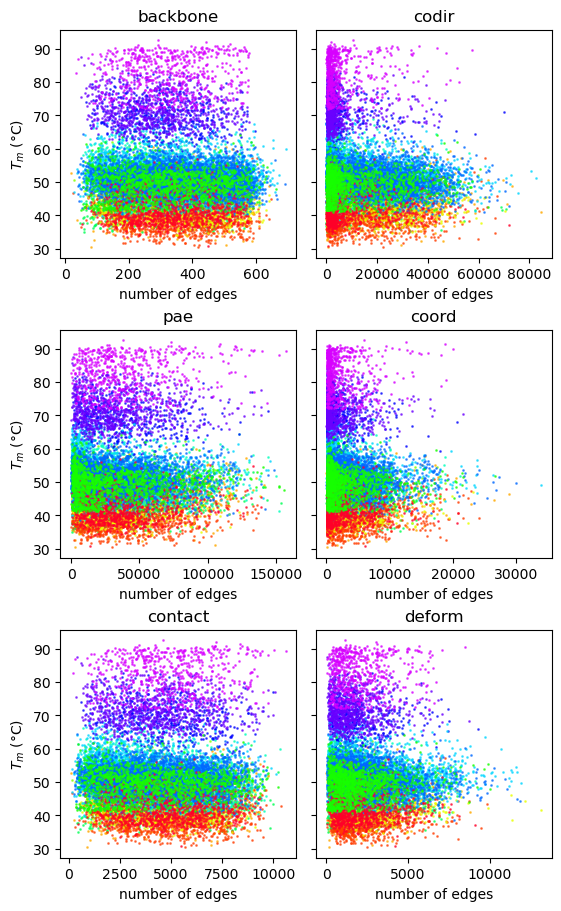

In [24]:
# edge count vs Tm

fig, ax = plt.subplots(
    3, 2, sharex=False, sharey=True, figsize=(5.5,9), layout='compressed'
)
ax = ax.flatten()

pbar = tqdm(edge_types)
for i, edge_type in enumerate(pbar):
    pbar.set_description(edge_type)

    for species in np.unique(all_species):
        ax[i].scatter(
            edge_count[edge_type][all_species==species],
            all_Tm[all_species==species],
            color=cm(species2idx[species]/len(species2idx)),
            s=1,
            alpha=0.6
        )
    
    ax[i].set_title(edge_type)

    ax[i].set_xlabel('number of edges')
    if i%2 == 0:
        ax[i].set_ylabel(r'$T_m$ (°C)')

if save:
    plt.savefig('edge_count_vs_Tm.png', dpi=300)#, bbox_inches='tight')
plt.show()
plt.close()